In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders
! pip install optuna

In [145]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative
import random
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from optuna.integration import _lightgbm_tuner as lgb_tuner
import optuna


from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [146]:
class CFG:
  exp = "exp23"
  seed = 71
  fold = 10

CONFIG = CFG()

In [147]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [148]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

# 処理済みデータ読み込み

In [149]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [150]:
df_train_org = df_train.copy()

In [151]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-21 21:38:07.200,2021-09-21 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-21 21:38:15.600,2021-09-21 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-21 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:21.200,NaT,1.0,14,14


In [152]:
df_train_0=df_train[df_train.event_type !=3].reset_index(drop=True)
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [153]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [154]:
# base
df_train3 = df_train3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])
df_test3 = df_test3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_train.columns=["customer_id","time_duration_frame","in_time"]
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_test.columns=["customer_id","time_duration_frame","in_time"]

# shopper area time
df_sub=df_train[df_train.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_train = df_sub[~df_sub.num_touch.isnull()]
df_area_train =df_area_train.drop_duplicates()
df_area_train = df_area_train[["customer_id","area_id","time_duration"]]
df_area_train.columns=["customer_id","area_id","time_duration_area"]

df_sub=df_test[df_test.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_test = df_sub[~df_sub.num_touch.isnull()]
df_area_test =df_area_test.drop_duplicates()
df_area_test = df_area_test[["customer_id","area_id","time_duration"]]
df_area_test.columns=["customer_id","area_id","time_duration_area"]

In [155]:
df_area_train

,customer_id,area_id,time_duration_area
1,20201026-010001,1.0,6.2
2,20201026-010001,1.0,6.2
4,20201026-010002,1.0,7.8
5,20201026-010002,1.0,7.8
7,20201026-010003,1.0,14.0
...,...,...,...
13475,20201101-120054,1.0,11.2
13476,20201101-120054,1.0,11.2
13477,20201101-120054,1.0,11.2
13479,20201101-120055,5.0,13.0


In [156]:
df_train = pd.merge(df_train3,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,df_area_train,on="customer_id")
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area', 'in_time', 'buy_flag'])
df_train = df_train.drop_duplicates()

df_test = pd.merge(df_test3,df_frametime_test,on="customer_id")
df_test = pd.merge(df_test,df_area_test,on="customer_id")
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area','in_time'])
df_test = df_test.drop_duplicates()

In [157]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


In [158]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time
0,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,8,11,19.8,7.2,2021-09-21 08:07:13.000
2,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,10,9,19.8,7.2,2021-09-21 08:07:13.000
4,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,8,12,21.2,4.8,2021-09-21 08:10:32.600
7,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,9,11,21.2,4.8,2021-09-21 08:10:32.600
10,20201026-010008,2020/10/26,man,40's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,12,8,21.2,4.8,2021-09-21 08:10:32.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,2020/11/1,man,20's,Young,優しい君500ml,ラボラトリー,2.0,9,19,28.6,16.8,2021-09-21 21:36:35.800
14618,20201101-120052,2020/11/1,man,20's,Young,ほっと一息500ml,エターナル,2.0,11,16,28.6,16.8,2021-09-21 21:36:35.800
14622,20201101-120052,2020/11/1,man,20's,Young,職人の力500ml,フューチャー,2.0,21,6,28.6,16.8,2021-09-21 21:36:35.800
14626,20201101-120056,2020/11/1,woman,30's,Young,匠の果実500ml,エターナル,1.0,15,7,22.6,15.2,2021-09-21 21:47:14.200


In [159]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0


In [160]:
df_train.buy_flag.value_counts()

1.0    4976
0.0    1798
Name: buy_flag, dtype: int64

# 前処理

## 容量のカラム追加

In [161]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [162]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


## 入時間の設定

In [163]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time_hour"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time_min"] = df_train["in_time"].apply(lambda x: x.minute)
df_train=df_train.drop(columns="in_time")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time_hour"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time_min"] = df_test["in_time"].apply(lambda x: x.minute)
df_test=df_test.drop(columns="in_time")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())

In [164]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
2,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
4,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
6,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
8,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
26419,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
26422,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
26425,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [165]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,11,19.8,7.2,8,7
2,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,9,19.8,7.2,8,7
4,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,8,12,21.2,4.8,8,10
7,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,9,11,21.2,4.8,8,10
10,20201026-010008,0,man,40's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,12,8,21.2,4.8,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,6,man,20's,Young,優しい君500ml,500,ラボラトリー,2.0,9,19,28.6,16.8,21,36
14618,20201101-120052,6,man,20's,Young,ほっと一息500ml,500,エターナル,2.0,11,16,28.6,16.8,21,36
14622,20201101-120052,6,man,20's,Young,職人の力500ml,500,フューチャー,2.0,21,6,28.6,16.8,21,36
14626,20201101-120056,6,woman,30's,Young,匠の果実500ml,500,エターナル,1.0,15,7,22.6,15.2,21,47


## 滞在時間での切り捨て

In [166]:
df_train.groupby("buy_flag").time_duration_frame.mean()

buy_flag
0.0    89.870189
1.0    47.108842
Name: time_duration_frame, dtype: float64

In [167]:
def time_duration_revise(x,col):
  if x >= 500:
    x=df_test[col].mean()
    return x
  else:
    return x

In [168]:
#外れ値保管
df_test["1in_3in"]=df_test["1in_3in"].apply(lambda x:time_duration_revise(x,"1in_3in"))
df_test["3in_1out"]=df_test["3in_1out"].apply(lambda x:time_duration_revise(x,"3in_1out"))
df_train=df_train[df_train["3in_1out"] < 500].reset_index(drop=True)

#Frame time cut for positive
del_df_train = df_train[(df_train.time_duration_frame > 100) & (df_train.buy_flag == 1)]
others_list=set(list(df_train.index)) ^ set(list(del_df_train.index)) 
df_train = df_train.loc[others_list].reset_index(drop=True)

#Frame time cut all
df_train=df_train[df_train["time_duration_frame"] < df_test["time_duration_frame"].max()].reset_index(drop=True)
df_train=df_train[df_train["time_duration_area"] < df_test["time_duration_area"].max()].reset_index(drop=True)
df_train=df_train[df_train["1in_3in"] < df_test["1in_3in"].max()].reset_index(drop=True)
df_train=df_train[df_train["3in_1out"] < df_test["3in_1out"].max()].reset_index(drop=True)


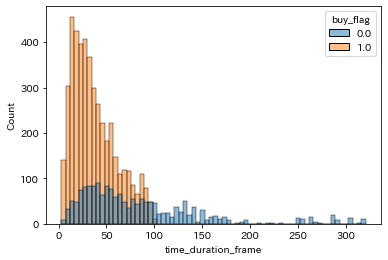

In [169]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

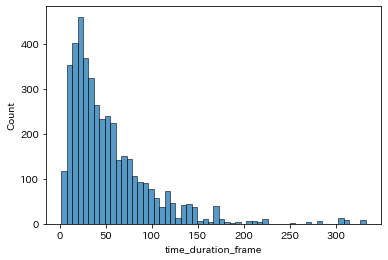

In [170]:
sns.histplot(data=df_test, x="time_duration_frame")

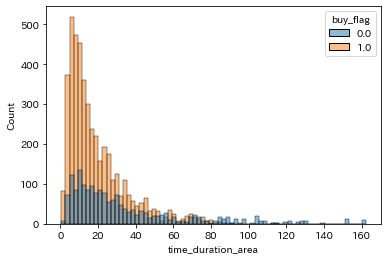

In [171]:
sns.histplot(data=df_train, x="time_duration_area",hue="buy_flag")

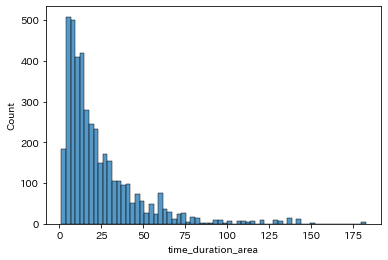

In [172]:
sns.histplot(data=df_test, x="time_duration_area")

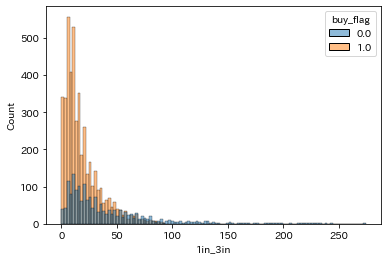

In [173]:
sns.histplot(data=df_train, x="1in_3in",hue="buy_flag")

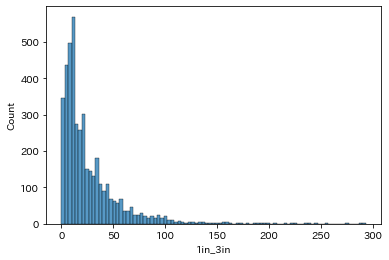

In [174]:
sns.histplot(data=df_test, x="1in_3in")

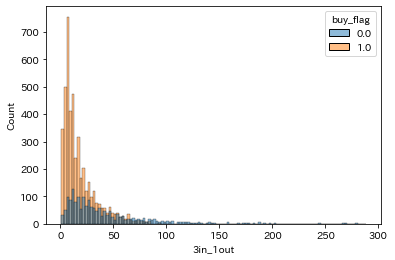

In [175]:
sns.histplot(data=df_train, x="3in_1out",hue="buy_flag")

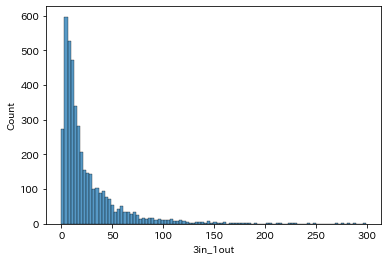

In [176]:
sns.histplot(data=df_test, x="3in_1out")

In [177]:
df_train.buy_flag.value_counts()

1.0    4571
0.0    1745
Name: buy_flag, dtype: int64

## オーバーサンプリング

In [178]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
6312,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
6313,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
6314,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [179]:
adasyn = SVMSMOTE(random_state = CONFIG.seed)
#sample_cols=["1in_3in", "3in_1out","time_duration_frame","time_duration_area","in_time_hour","in_time_min"]
sample_cols=["time_duration_frame","time_duration_area"]

#対象カラムのオーバーサンプリング
X, y = adasyn.fit_resample(df_train[sample_cols], df_train['buy_flag'])
df_oversample = pd.DataFrame(X, columns = sample_cols)
df_oversample["buy_flag"]=y
add_samples=df_oversample.iloc[list(df_train.index)[-1]+1:]

#buy_flag=0のrow複製
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [180]:
#オーバサンプリングした数値の上書き
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

In [181]:
for i in sample_cols:
  add_df[i]=add_samples[i].values

In [182]:
add_df

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
4160,20201031-010099,5,woman,30's,Young,おいしい新茶470ml,470,イッツ園,1.0,27,21,24.757688,18.619190,0.0,9,58
269,20201026-020204,0,man,40's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,44,65,53.600000,5.800000,0.0,12,52
4611,20201031-040123,5,man,50's,Middle,新緑の丘525ml,525,フューチャー,1.0,19,48,77.514188,7.790655,0.0,15,51
1857,20201028-020153,2,woman,50's,Middle,玉露水525ml,525,ラボラトリー,5.0,30,110,89.776303,17.971834,0.0,12,41
2878,20201029-040157,3,man,10's,Teen,コーヒー牛乳500ml,500,ラボラトリー,2.0,228,62,81.200000,40.000000,0.0,16,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727,20201031-050119,5,woman,10's,Teen,はじけたグレープ500ml,500,フューチャー,3.0,30,56,79.868209,16.993060,0.0,16,34
4844,20201031-060144,5,man,10's,Teen,ミックスフルーツドリンク500ml,500,大自然カンパニー,4.0,18,132,64.687155,24.000000,0.0,17,42
910,20201027-010182,1,woman,60's,Senior,ザ玉露600ml,600,クオリティー,1.0,98,9,26.800000,20.600000,0.0,10,17
4395,20201031-020247,5,woman,20's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,41,144,78.220862,42.158275,0.0,12,40


In [183]:
df_train = pd.concat([df_train,add_df],axis=0).reset_index(drop=True)

In [184]:
df_train.buy_flag.value_counts()

0.0    4571
1.0    4571
Name: buy_flag, dtype: int64

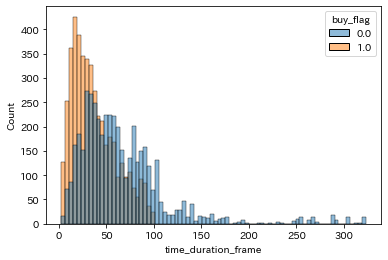

In [185]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

In [186]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201031-050119,5,woman,10's,Teen,はじけたグレープ500ml,500,フューチャー,3.0,30,56,79.868209,16.993060,0.0,16,34
9138,20201031-060144,5,man,10's,Teen,ミックスフルーツドリンク500ml,500,大自然カンパニー,4.0,18,132,64.687155,24.000000,0.0,17,42
9139,20201027-010182,1,woman,60's,Senior,ザ玉露600ml,600,クオリティー,1.0,98,9,26.800000,20.600000,0.0,10,17
9140,20201031-020247,5,woman,20's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,41,144,78.220862,42.158275,0.0,12,40


## Area外滞在時間/Area滞在時間率

In [187]:
df_train["time_frameout"] = df_train["time_duration_frame"] - df_train["time_duration_area"]
df_test["time_frameout"] = df_test["time_duration_frame"] - df_test["time_duration_area"]

In [188]:
df_train["time_area_rate"] = df_train["time_duration_area"] / df_train["time_duration_frame"]
df_test["time_area_rate"] = df_test["time_duration_area"] / df_test["time_duration_frame"]

In [189]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1,0.000000,1.000000
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1,0.000000,1.000000
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,2,5.800000,0.573529
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,2,5.800000,0.573529
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,2,0.200000,0.985915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201031-050119,5,woman,10's,Teen,はじけたグレープ500ml,500,フューチャー,3.0,30,56,79.868209,16.993060,0.0,16,34,62.875149,0.212764
9138,20201031-060144,5,man,10's,Teen,ミックスフルーツドリンク500ml,500,大自然カンパニー,4.0,18,132,64.687155,24.000000,0.0,17,42,40.687155,0.371016
9139,20201027-010182,1,woman,60's,Senior,ザ玉露600ml,600,クオリティー,1.0,98,9,26.800000,20.600000,0.0,10,17,6.200000,0.768657
9140,20201031-020247,5,woman,20's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,41,144,78.220862,42.158275,0.0,12,40,36.062587,0.538965


## ターゲットエンコーディング（購入率）

In [190]:
def target_encoding(df,df_1,col):

  rate_df=df_train.groupby(col).buy_flag.sum().reset_index().set_index(col)
  count_df=df_train.groupby(col).customer_id.count().reset_index().set_index(col)

  cvr_df=pd.concat([rate_df,count_df],axis=1)
  cvr_df["cvr_rate_"+str(col)]=cvr_df["buy_flag"] / cvr_df["customer_id"]
  cvr_df=cvr_df.drop(columns=["buy_flag","customer_id"])
  cvr_df=cvr_df.reset_index()

  df = pd.merge(df,cvr_df,on=col)
  df_1 = pd.merge(df_1,cvr_df,on=col)

  return df,df_1

In [191]:
target_cols=['event_day',
             'gender', 
             'age',
             'age_category',
             'product_name', 
             'size',
             'company',
             'area_id',
             'in_time_hour']

for col in target_cols:
  df_train,df_test=target_encoding(df_train,df_test,col)

In [192]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1,0.000000,1.000000,0.543221,0.490659,0.561732,0.570555,0.735395,0.560209,0.647535,0.532866,0.562347
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1,0.000000,1.000000,0.543221,0.490659,0.561732,0.570555,0.735395,0.560209,0.647535,0.532866,0.562347
2,20201027-010002,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,17,2,19.400000,8.200000,1.0,8,2,11.200000,0.422680,0.471892,0.490659,0.561732,0.570555,0.735395,0.560209,0.647535,0.532866,0.562347
3,20201027-010049,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,12,30,43.000000,7.800000,1.0,8,43,35.200000,0.181395,0.471892,0.490659,0.561732,0.570555,0.735395,0.560209,0.647535,0.532866,0.562347
4,20201026-010050,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,16,7,23.800000,12.200000,1.0,8,50,11.600000,0.512605,0.543221,0.510653,0.561732,0.570555,0.735395,0.560209,0.647535,0.532866,0.562347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,57.200000,5.600000,0.0,15,4,51.600000,0.097902,0.525603,0.510653,0.590593,0.551390,0.063927,0.144254,0.078176,0.450321,0.405702
9138,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,11,45,57.200000,5.600000,1.0,15,4,51.600000,0.097902,0.525603,0.510653,0.590593,0.551390,0.063927,0.144254,0.078176,0.450321,0.405702
9139,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,38.280114,6.719697,0.0,15,4,31.560417,0.175540,0.525603,0.510653,0.590593,0.551390,0.063927,0.144254,0.078176,0.450321,0.405702
9140,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,22.446994,22.446994,0.0,15,4,0.000000,1.000000,0.525603,0.510653,0.590593,0.551390,0.063927,0.144254,0.078176,0.450321,0.405702


In [193]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,11.0,19.8,7.2,8,7,12.6,0.363636,0.543221,0.510653,0.517385,0.551390,0.798319,0.560209,0.647535,0.532866,0.562347
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,9.0,19.8,7.2,8,7,12.6,0.363636,0.543221,0.510653,0.517385,0.551390,0.798319,0.560209,0.647535,0.532866,0.562347
2,20201029-010002,3,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,4.0,14.4,5.2,8,1,9.2,0.361111,0.538949,0.510653,0.517385,0.551390,0.798319,0.560209,0.647535,0.532866,0.562347
3,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,10.0,18.4,7.2,8,7,11.2,0.391304,0.511924,0.510653,0.517385,0.551390,0.798319,0.560209,0.647535,0.532866,0.562347
4,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,8.0,18.4,7.2,8,7,11.2,0.391304,0.511924,0.510653,0.517385,0.551390,0.798319,0.560209,0.647535,0.532866,0.562347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,20201101-050032,6,woman,40's,Middle,黒の息吹500ml,500,モーリーフラフト,2.0,51.0,13.0,64.8,37.8,13,13,27.0,0.583333,0.525603,0.490659,0.517385,0.551390,0.481818,0.516720,0.329317,0.450321,0.557947
4290,20201101-050032,6,woman,40's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,44.0,20.0,64.8,37.8,13,13,27.0,0.583333,0.525603,0.490659,0.517385,0.551390,0.208633,0.275701,0.329317,0.450321,0.557947
4291,20201029-030110,3,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,36.0,13.0,50.0,35.8,13,59,14.2,0.716000,0.538949,0.490659,0.561732,0.570555,0.208633,0.275701,0.329317,0.450321,0.557947
4292,20201031-030018,5,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,14.0,11.0,25.8,10.8,13,5,15.0,0.418605,0.415576,0.490659,0.561732,0.570555,0.208633,0.275701,0.329317,0.450321,0.557947


## カテゴリーのエンコーディング

In [194]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [195]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            #'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [196]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [197]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_test_oe],axis=1)

# モデル作成　(Light GBM)

In [198]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [199]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        #border = y_valid.sum() / len(x_valid)

        #print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        #pred_i = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_i) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

In [ ]:
def fit_lgbm_param_optuna(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = roc_auc_score

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 

        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred
        models.append(clf)

        score=metric_func(y_valid, pred)

    return score

def objective_lgbm(trial):

    fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

    train_x=df_train_encoded.drop(columns=["customer_id"])
    train_x = train_x.iloc[:,:-1]
    train_y = df_train_encoded["buy_flag"]
    
    fold = KFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    cv = list(fold.split(train_x, train_y))

    optuna_paramas_lgb = {
        'objective': "binary",
        'class_weight':"balanced",
        'learning_rate': trial.suggest_float('learning_rate',0.01,0.05),
        'random_state' : 71,
        'max_depth': trial.suggest_int('max_depth', 2, 20)}


    score = fit_lgbm_param_optuna(train_x.values,  train_y, cv=cv, params=optuna_paramas_lgb)
    print("Score:"+str(score))
    
    return score

study = optuna.create_study(direction="minimize", study_name='lgb_train')
study.optimize(objective_lgbm, n_trials=10)

[I 2021-09-22 16:14:31,259] A new study created in memory with name: lgb_train


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.446061
[100]	valid_0's binary_logloss: 0.387389
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.387389
fit fold=1 0.422[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.440226
[100]	valid_0's binary_logloss: 0.379799
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.379799
fit fold=2 0.430[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.442029
[100]	valid_0's binary_logloss: 0.387777
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.387777
fit fold=3 0.469[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.44941
[100]	valid_0's binary_logloss: 0.399068
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.399068
fit fold=4 0.

[I 2021-09-22 16:14:35,816] Trial 0 finished with value: 0.9017333563297689 and parameters: {'learning_rate': 0.026878393340078063, 'max_depth': 12}. Best is trial 0 with value: 0.9017333563297689.


Score:0.9017333563297689
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.544748
[100]	valid_0's binary_logloss: 0.486083
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.486083
fit fold=1 0.263[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.539117
[100]	valid_0's binary_logloss: 0.481142
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.481142
fit fold=2 0.270[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.537102
[100]	valid_0's binary_logloss: 0.48089
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.48089
fit fold=3 0.263[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.546985
[100]	valid_0's binary_logloss: 0.492156
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss

[I 2021-09-22 16:14:38,600] Trial 1 finished with value: 0.8704534130543099 and parameters: {'learning_rate': 0.014186951405380427, 'max_depth': 4}. Best is trial 1 with value: 0.8704534130543099.


[100]	valid_0's binary_logloss: 0.49034
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.49034
fit fold=10 0.273[s]
Score:0.8704534130543099
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.525218
[100]	valid_0's binary_logloss: 0.48796
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.48796
fit fold=1 0.164[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.53141
[100]	valid_0's binary_logloss: 0.492716
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.492716
fit fold=2 0.160[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.526202
[100]	valid_0's binary_logloss: 0.486452
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.486452
fit fold=3 0.169[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_

[I 2021-09-22 16:14:40,404] Trial 2 finished with value: 0.8444770227281438 and parameters: {'learning_rate': 0.04184492071484594, 'max_depth': 2}. Best is trial 2 with value: 0.8444770227281438.


[100]	valid_0's binary_logloss: 0.482257
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.482257
fit fold=9 0.175[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.530843
[100]	valid_0's binary_logloss: 0.49492
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.49492
fit fold=10 0.171[s]
Score:0.8444770227281438
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.441817
[100]	valid_0's binary_logloss: 0.382635
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.382635
fit fold=1 0.433[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.435696
[100]	valid_0's binary_logloss: 0.375972
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.375972
fit fold=2 0.439[s]
Training until validation scores don't improve for 50 rounds.
[50]	val

[I 2021-09-22 16:14:44,958] Trial 3 finished with value: 0.9019585297612204 and parameters: {'learning_rate': 0.0277888736067953, 'max_depth': 20}. Best is trial 2 with value: 0.8444770227281438.


fit fold=10 0.442[s]
Score:0.9019585297612204
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.541557
[100]	valid_0's binary_logloss: 0.48731
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.48731
fit fold=1 0.221[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.538567
[100]	valid_0's binary_logloss: 0.487439
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.487439
fit fold=2 0.204[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.538989
[100]	valid_0's binary_logloss: 0.483404
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.483404
fit fold=3 0.221[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.548069
[100]	valid_0's binary_logloss: 0.498658
Did not meet early stopping. Best iteration is:
[100]	val

[I 2021-09-22 16:14:47,196] Trial 4 finished with value: 0.8629292667969798 and parameters: {'learning_rate': 0.019152370044684838, 'max_depth': 3}. Best is trial 2 with value: 0.8444770227281438.


[100]	valid_0's binary_logloss: 0.494442
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.494442
fit fold=10 0.217[s]
Score:0.8629292667969798
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.429651
[100]	valid_0's binary_logloss: 0.376408
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.376408
fit fold=1 0.415[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.422957
[100]	valid_0's binary_logloss: 0.365259
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.365259
fit fold=2 0.452[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.426654
[100]	valid_0's binary_logloss: 0.376643
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.376643
fit fold=3 0.418[s]
Training until validation scores don't improve for 50 rounds.
[50]	v

[I 2021-09-22 16:14:51,550] Trial 5 finished with value: 0.9047133111034455 and parameters: {'learning_rate': 0.03223374311273223, 'max_depth': 10}. Best is trial 2 with value: 0.8444770227281438.


[50]	valid_0's binary_logloss: 0.438499
[100]	valid_0's binary_logloss: 0.392538
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.392538
fit fold=10 0.415[s]
Score:0.9047133111034455
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.604715
[100]	valid_0's binary_logloss: 0.559943
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.559943
fit fold=1 0.177[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.605854
[100]	valid_0's binary_logloss: 0.56326
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.56326
fit fold=2 0.181[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.604731
[100]	valid_0's binary_logloss: 0.560804
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.560804
fit fold=3 0.177[s]
Training until validation scor

[I 2021-09-22 16:14:53,444] Trial 6 finished with value: 0.8328518454639532 and parameters: {'learning_rate': 0.01272233051537313, 'max_depth': 2}. Best is trial 6 with value: 0.8328518454639532.


[50]	valid_0's binary_logloss: 0.605255
[100]	valid_0's binary_logloss: 0.56207
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.56207
fit fold=10 0.182[s]
Score:0.8328518454639532
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.444074
[100]	valid_0's binary_logloss: 0.407906
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.407906
fit fold=1 0.324[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.440995
[100]	valid_0's binary_logloss: 0.402353
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.402353
fit fold=2 0.299[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.439194
[100]	valid_0's binary_logloss: 0.403353
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.403353
fit fold=3 0.304[s]
Training until validation scor

[I 2021-09-22 16:14:56,645] Trial 7 finished with value: 0.8892194626499561 and parameters: {'learning_rate': 0.03991194091884475, 'max_depth': 5}. Best is trial 6 with value: 0.8328518454639532.


[100]	valid_0's binary_logloss: 0.418593
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.418593
fit fold=10 0.299[s]
Score:0.8892194626499561
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.554756
[100]	valid_0's binary_logloss: 0.494856
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.494856
fit fold=1 0.263[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.549526
[100]	valid_0's binary_logloss: 0.489753
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.489753
fit fold=2 0.266[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.547542
[100]	valid_0's binary_logloss: 0.490486
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.490486
fit fold=3 0.262[s]
Training until validation scores don't improve for 50 rounds.
[50]	v

[I 2021-09-22 16:14:59,454] Trial 8 finished with value: 0.8696173968034955 and parameters: {'learning_rate': 0.012686169342790165, 'max_depth': 4}. Best is trial 6 with value: 0.8328518454639532.


[100]	valid_0's binary_logloss: 0.499018
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.499018
fit fold=10 0.264[s]
Score:0.8696173968034955
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.441869
[100]	valid_0's binary_logloss: 0.383322
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.383322
fit fold=1 0.466[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.435661
[100]	valid_0's binary_logloss: 0.376821
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.376821
fit fold=2 0.424[s]
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.437953
[100]	valid_0's binary_logloss: 0.384227
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.384227
fit fold=3 0.452[s]
Training until validation scores don't improve for 50 rounds.
[50]	v

In [257]:
study.best_params

{'learning_rate': 0.020762490271785852,
 'max_depth': 7,
 'min_child_samples': 40}

## 学習

In [231]:
fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x=df_train_encoded.drop(columns=["customer_id"])
train_x = train_x.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=study.best_params)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.466524
[100]	valid_0's binary_logloss: 0.432178
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.432178
fit fold=1 0.318[s]
AUC 0 Score: 0.8852
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.459026
[100]	valid_0's binary_logloss: 0.422217
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.422217
fit fold=2 0.295[s]
AUC 1 Score: 0.8919
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.456475
[100]	valid_0's binary_logloss: 0.419551
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.419551
fit fold=3 0.284[s]
AUC 2 Score: 0.8903
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.46369
[100]	valid_0's binary_logloss: 0.434235
Did not meet early stopping. Best iteratio

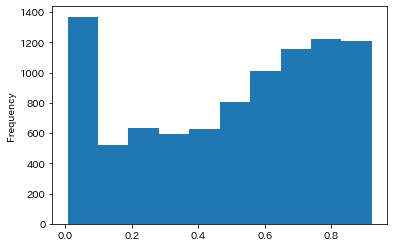

In [232]:
oof["pred_prob"].plot(kind="hist")

In [233]:
df_train_encoded[["customer_id"]]

,customer_id
0,20201026-010001
1,20201026-010001
2,20201027-010002
3,20201027-010049
4,20201026-010050
...,...
9137,20201101-070012
9138,20201101-070012
9139,20201101-070012
9140,20201101-070012


In [234]:
train_pred_1=pd.concat([oof[["pred_prob","y"]],df_train_encoded[["customer_id"]]],axis=1).set_index("customer_id")

In [235]:
a=df_train_org[df_train_org.event_type!=3].customer_id.unique()
b=df_train_org[df_train_org.event_type==3].customer_id.unique()
others_list=list(set(list(a)) ^ set(list(b)) )

train_pred_0 = pd.DataFrame()
train_pred_0["customer_id"] = others_list
train_pred_0["pred_prob"] = 0
train_pred_0["y"] = 0
train_pred_0=train_pred_0.set_index("customer_id")
train_pred=pd.concat([train_pred_1,train_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [236]:
score = roc_auc_score(train_pred["y"], train_pred["pred_prob"]) 
print('Train | AUC Score: {:.4f}'.format(score))

Train | AUC Score: 0.9375


## 学習結果

In [237]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

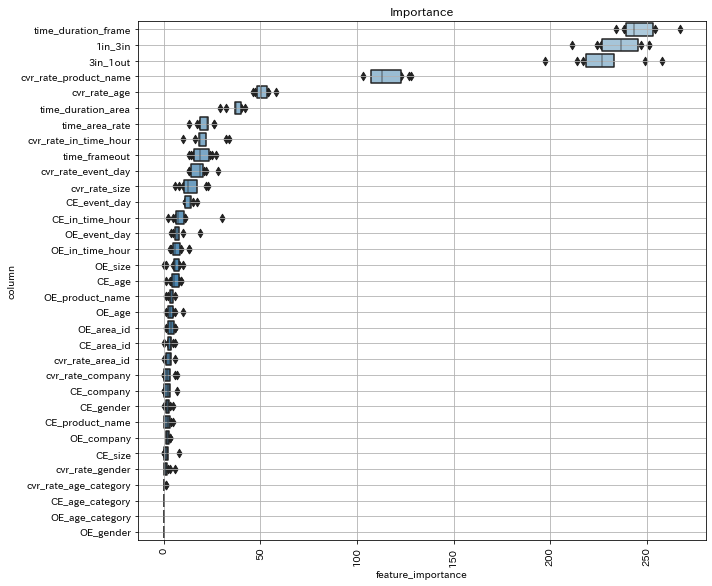

In [238]:
fig, ax = visualize_importance(models, train_x)

In [239]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

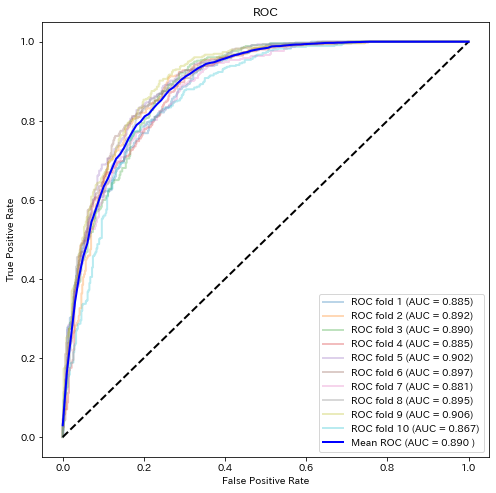

In [240]:
visulalize_roc(oof,CONFIG.fold)

In [241]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

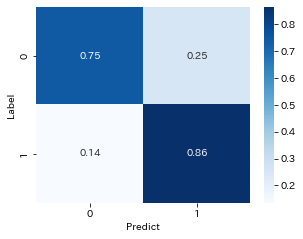

In [242]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [243]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict_proba(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)[:, 1]
#pred = np.where(pred < 0.5, 0, 1)

In [244]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [245]:
submission_pred = submission_pred.groupby("customer_id").max()

In [246]:
submission_pred

,buy_proba
customer_id,
20201026-010006,0.880795
20201026-010008,0.871752
20201026-010011,0.825164
20201026-010012,0.899182
20201026-010018,0.498241
...,...
20201101-120031,0.906522
20201101-120033,0.587188
20201101-120051,0.854813


In [247]:
#submission_pred=submission_pred.groupby("customer_id").mean().reset_index()
#pred = np.where( submission_pred["buy_proba"].values<0.5, 0, 1)
#submission_pred["buy_proba"]=pred
#submission_pred=submission_pred.set_index("customer_id")

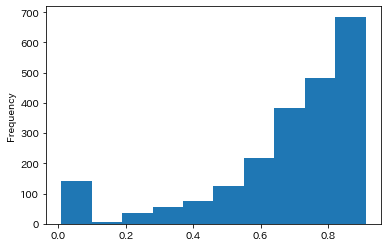

In [248]:
submission_pred["buy_proba"].plot(kind="hist")

In [249]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["customer_id"]
submission_pred_0["buy_proba"] = 0
submission_pred_0 = submission_pred_0.drop_duplicates()
submission_pred_0=submission_pred_0.set_index("customer_id")

others_list=set(list(submission_pred.index)) ^ set(list(submission_pred_0.index)) 
submission_pred_0 = submission_pred_0.loc[others_list]

In [250]:
submission_pred_0

,buy_proba
customer_id,
20201031-050072,0
20201028-030096,0
20201026-020009,0
20201027-050163,0
20201029-030159,0
...,...
20201031-060098,0
20201029-060069,0
20201026-020270,0


In [251]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [252]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,0.880795
1,20201026-010008,0.871752
2,20201026-010011,0.825164
3,20201026-010012,0.899182
4,20201026-010018,0.498241
...,...,...
4525,20201101-120039,0.000000
4526,20201101-120046,0.000000
4527,20201101-120051,0.854813
4528,20201101-120052,0.787240


In [253]:
submission_pred_all.buy_proba.value_counts()

0.000000    2326
0.890554       2
0.886104       2
0.752456       1
0.802959       1
            ... 
0.760121       1
0.562412       1
0.660165       1
0.304973       1
0.752714       1
Name: buy_proba, Length: 2203, dtype: int64

In [254]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)